# Quantile Regression
#### How does DoorDash know when your food will arrive? 

In [ ]:
# Quantile Regression: used to generate bounds (i.e. DoorDash: "Your order will arive in 25 to 35 minutes")
# Loss Function: L = (y - Xθ)^2
# Quantile Loss Function: L = τ(y - Xθ)        if y - Xθ >= 0 : predicted value low, used for low quantiles, penalizes high
                        #     (τ - 1)(y - Xθ)  if y - Xθ < 0  : predicted value high, used for high quantiles, penalizes low
# Penalize the Loss When: 
#     the percentile τ is low, but the prediction is Xθ is high
#     the percentile τ is high, but the prediction is Xθ is low


# Build a regression model that generates a delivery time based on the distance between the store and the customer

In [1]:
from sklearn.datasets import make_regression # generates regression dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor # MS's graded boosted decision trees 

In [3]:
X, y = make_regression(n_samples=10000,
                      n_features=1, # distance
                      n_informative=1,
                      n_targets=1,
                      random_state=20 # toggle to change describe
                      )

Xs = pd.DataFrame(X, columns = ['distance']) # next step would be to add in a traffic variable
ys = pd.DataFrame(y, columns = ['time_to_customer'])

# adding noise and shifting mean and standard deviation to represent distance
Xs['distance'] = Xs['distance'].apply(lambda x: 10 + 2 * (x + np.random.normal(loc=1)))
ys['time_to_customer'] = ys['time_to_customer'].apply(lambda x: 60 + 0.3 * (x + np.random.normal(loc=1)))

In [4]:
# create our dataset for quantile regression
df = Xs.merge(ys, left_index=True, right_index=True)

In [5]:
# did our manipulation work?
df.describe()

,distance,time_to_customer
count,10000.000000,10000.000000
mean,12.043276,60.478030
std,2.845144,11.268023
min,-0.197749,17.232299
25%,10.132853,52.785487
50%,12.048006,60.542500
75%,13.923884,68.040824
max,23.017197,105.971735


In [6]:
# split the dataset into training and testing
train_df, test_df = train_test_split(df, test_size=0.10, shuffle=False)

In [7]:
# split both datasets into X and y components for quantile regression
X_train, y_train = train_df[['distance']], train_df[['time_to_customer']]
X_test, y_test = test_df[['distance']], test_df[['time_to_customer']]

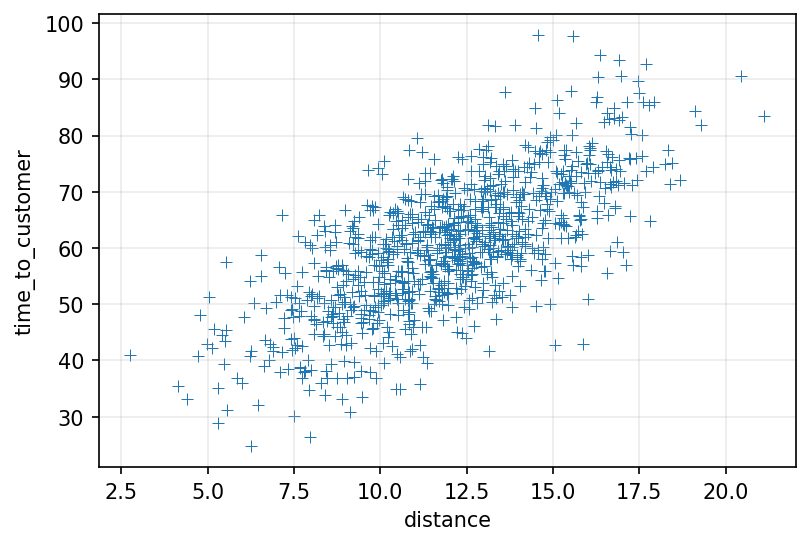

In [29]:
# time to visualize the data
plt.rcParams.update({'font.size': 10, 'figure.dpi': 150})
sns.scatterplot(data=test_df, x="distance", y="time_to_customer", marker='+')
plt.grid(linestyle='-', linewidth=0.2)
# looks like a linear relationship between the distance and the time to customer

In [12]:
# training process
classifiers = {}
# what range do we want? 20% to 90% guarantee for order delivery
for tau in [0.2, 0.5, 0.9]:
    clf = LGBMRegressor(objective='quantile', alpha=tau) # minimize quantile loss at each tau value
    clf.fit(X_train, y_train) # fit the model
    preds = pd.DataFrame(clf.predict(X_test), columns=[str(tau)]) # make predictions on test set
    classifiers[str(tau)] = {'clf':clf, 'predictions':preds} # append to dictionary for each tau value and prediction

In [13]:
# constructing a dataset from all of the predicted values and the time to customer label (actual)
data = pd.DataFrame({'distance': X_test.reset_index()['distance'],
                    '0.2': classifiers['0.2']['predictions']['0.2'],
                    '0.5': classifiers['0.5']['predictions']['0.5'],
                    '0.9': classifiers['0.9']['predictions']['0.9'],
                    'time_to_customer': y_test.reset_index()['time_to_customer']})

In [17]:
data.sample(10)
# do we want to go lower than 20%?
# time is in minutes fyi

,distance,0.2,0.5,0.9,time_to_customer
180,9.429268,45.965615,52.851288,64.241459,46.719097
421,6.783736,37.890951,44.313913,55.748111,40.066619
375,15.053385,62.002235,67.496438,80.685356,57.340235
629,14.676095,63.174147,67.797425,75.729825,76.739769
548,6.250408,40.739353,45.263351,53.617491,41.713287
598,15.333380,63.529420,71.172482,82.445708,71.521379
958,18.320756,71.115396,77.834656,94.474118,77.398925
269,5.291565,34.822790,38.459365,50.097645,28.830552
340,12.958625,54.494212,63.461216,73.295163,67.292821
872,7.064860,40.187868,45.306285,56.411438,56.639415


In [18]:
# convert all columns into a single row of values with corresponding value in each cell reflected in the value column
melted_data = pd.melt(data, id_vars=['distance'])

In [19]:
# done for the plot below
melted_data

,distance,variable,value
0,8.888933,0.2,48.784958
1,12.628849,0.2,57.477403
2,15.364153,0.2,64.466784
3,10.834515,0.2,49.798472
4,9.217978,0.2,46.371388
...,...,...,...
3995,14.147319,time_to_customer,74.343479
3996,10.620405,time_to_customer,54.057935
3997,13.620644,time_to_customer,71.929127
3998,11.934400,time_to_customer,67.120018


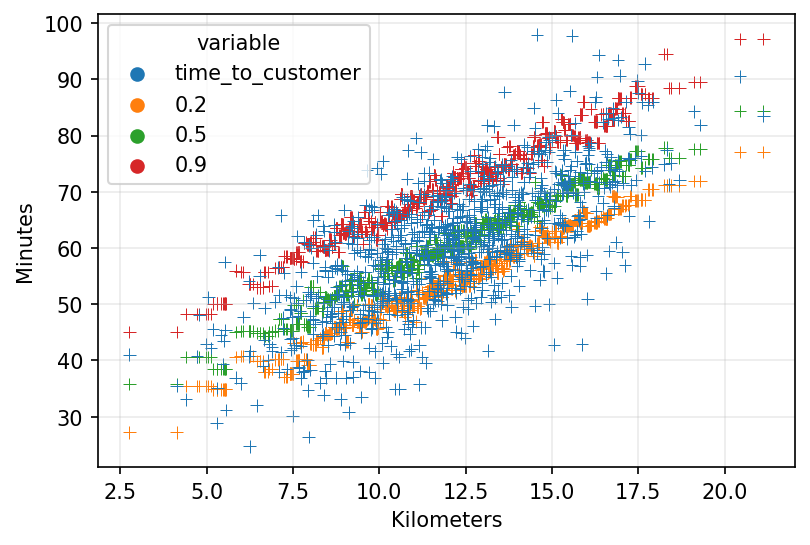

In [30]:
# plot the 20th, 50th, and 90th percentile against the actual data
plt.rcParams.update({'font.size': 10, 'figure.dpi':150})
sns.scatterplot(data=melted_data,
               x='distance',
               y='value',
               hue='variable',
               hue_order=['time_to_customer', '0.2', '0.5', '0.9'],
               marker='+')
plt.grid(linestyle='-', linewidth=0.2)
ylabel = plt.ylabel("Minutes")
xlabel = plt.xlabel("Kilometers")

In [35]:
# shows that the 50th quantile really is as ~500 values are below (false) and ~500 values are above (true)
(data['time_to_customer'] > data['0.5']).value_counts()

False    509
True     491
dtype: int64